<a href="https://colab.research.google.com/github/SAR-DEFE/Informalidad/blob/main/informalidad_hond_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Implementacion del modelo de Equilibrio General Dinamico para determinar la informalidad<h1>

En este notebook mostraremos como se puede estimar la informalidad según el modelo propuesto por Elguin y Oztunali (2012) con Python. Primero importartemos las librerías que se utilizarán

Proyecto en:

https://github.com/SAR-DEFE/Informalidad


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
import os
from openpyxl import load_workbook
pd.set_option('display.max_columns', 30)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


print("Setup Complete")




Setup Complete


Recordemos la representación de la economía que estamos utilizando:
<h1>
$ \max_{{(𝐶_𝑡,𝑋_𝑡,𝑁_{𝑆𝑡},𝑁_{𝐹𝑡})}_{𝑡=0}^\infty} $
$ \sum \limits _{𝑡=0} ^\infty \beta^𝑡 𝑈(𝐶_t)  $

Sujeto a:

$𝐶_𝑡+𝑋_𝑡=(1−\tau_𝑡 ) \theta_{𝐹𝑡} 𝐾_𝑡^\alpha 𝑁_{𝐹𝑡}^{1−\alpha}+\theta_{𝑆𝑡} 𝑁_{𝑆𝑡}^\gamma $  (1)

$𝐾_{𝑡+1}=𝑋_𝑡+(1−\delta) 𝐾_𝑡$    (2)

$𝑁_{𝑠𝑡}+𝑁_{𝐹𝑡}=𝐻_𝑡$   (3)
<h1>

A continuación se cargan los parámetros que se utilizarán

In [ ]:
alfa=0.36+0.07 #Semi elasticidad del capital (original 0.36, se usa 0.43 para ajustarse al dato de la productividad del trabajo (0,57) de Penn World Table para honduras)
delta=0.05 #Tasa de depreciación
gamma=0.425-0.1 # Semi elasticidad del trabajo informal 0.425-0.1 

#crec_t1=-0.0896476018404586 #tasa de crecimiento de la economía en el año 2020: viene el dato en la planilla "modelo_EGD"
#anno_ana=2019

ano_calib=2017
por_calib=0.439465713500976 #en esta version se recoge la ultima estimacion disponible para Honduras de la Informalidad del Banco Mundial (https://www.worldbank.org/en/research/brief/informal-economy-database)

#por_calib=(0.439465713500976+0.455540084838867)/2

#ano_calib=2018
#por_calib=0.455540084838867 #en esta version se recoge la ultima estimacion disponible para Honduras de la Informalidad del Banco Mundial (MIMIC) (https://www.worldbank.org/en/research/brief/informal-economy-database)


#anno_ana_menos1=anno_ana-1
#anno_ana_mas1=anno_ana+1

print('alfa:',alfa,', delta:', delta,', gamma:',  gamma,' informalidad pivote', por_calib)

alfa: 0.43 , delta: 0.05 , gamma: 0.32499999999999996  informalidad pivote 0.439465713500976


In [ ]:
def sis_eq(p):
  s_theta_S, s_ns=p
  aux1=(s_theta_F*(s_stock_k**alfa)*(s_nf **(1-alfa)))
  aux2=gamma/((1-s_carga)*(1-alfa)*s_theta_F)
  aux3=(((1+s_g_cp)/beta-1+delta)/(alfa*(1-s_carga)*s_theta_F))**(alfa/(1-alfa))
  
  return( ((s_theta_S*(s_ns**gamma))/aux1)-por_calib,  # Esta es la ecuacion de la informalidad
         ((s_theta_S*aux2*aux3)**(1/(1-gamma)))-s_ns   # Esta es la ecuacion del trabajo informal
      )

Luego, se cargan los datos de cuentas nacionales para realizar la estimación

In [ ]:
# Se debe fijar la pagina para obtener los datos

modelo_EGD_0=pd.read_csv("https://raw.githubusercontent.com/SAR-DEFE/Informalidad/main/modelo_EGD_v1.csv?token=GHSAT0AAAAAAB3ZECU7KJFI5RDYEAXBBDGUY4QU23A")




In [ ]:
modelo_EGD=modelo_EGD_0.copy()
modelo_EGD=modelo_EGD.query('2000<fecha<=2021')

modelo_EGD=modelo_EGD.append(pd.DataFrame(data={'fecha': [modelo_EGD['fecha'].max()+1], 'pib_real': [0]}), ignore_index=True)

print(modelo_EGD.dtypes)
modelo_EGD.head()

fecha          int64
stock_k      float64
fbc          float64
cp           float64
pib_real     float64
rec_total    float64
pib_nom      float64
nf           float64
dtype: object


,fecha,stock_k,fbc,cp,pib_real,rec_total,pib_nom,nf
0,2001,287136.0,26660.1,78884.8,109558.6,16083.21,118415.7,628.0
1,2002,297497.5,24718.3,82184.8,113671.8,17228.94,129166.6,644.0
2,2003,308870.4,26247.8,85803.0,118840.5,19632.37,142817.8,606.0
3,2004,325809.5,32382.6,90075.1,126247.0,23411.65,161507.5,656.0
4,2005,341437.3,31918.3,95605.0,133885.7,26707.63,183747.4,706.0


In [ ]:
modelo_EGD['nf']=np.where(modelo_EGD['fecha']==2020,1028*1+950*0, modelo_EGD['nf'])
modelo_EGD['nf']=np.where(modelo_EGD['fecha']==2021,1080*1+2500*0, modelo_EGD['nf'])
modelo_EGD.tail()

modelo_EGD['carga']=modelo_EGD['rec_total']/modelo_EGD['pib_nom'] #Carga Tributaria
modelo_EGD['g_cp']=modelo_EGD['cp']/modelo_EGD['cp'].shift(1)  #Crec. Cons. Privado
modelo_EGD['r_pib_k']=modelo_EGD['pib_real']/(modelo_EGD['stock_k']) #PIB/K

modelo_EGD['abeta']=(modelo_EGD['cp'].shift(-1)/modelo_EGD['cp'])/((1-modelo_EGD['carga'])*alfa*modelo_EGD['r_pib_k'].shift(-1)+1-delta) #betas anuales

beta=modelo_EGD['abeta'].mean()
print('beta: ', beta)

modelo_EGD['theta_F']=modelo_EGD['pib_real']/((modelo_EGD['stock_k']**alfa)*(modelo_EGD['nf']**(1-alfa)))

modelo_EGD['crec_theta_S']=(( modelo_EGD['stock_k']/modelo_EGD['stock_k'].shift(1))+( modelo_EGD['theta_F'])/modelo_EGD['theta_F'].shift(1))/2

valores_orig=modelo_EGD.copy()


# Obteniendo los valores para calibrar el año pivote
s_theta_F=valores_orig.loc[valores_orig['fecha']==ano_calib, 'theta_F'].values[0]
s_carga =valores_orig.loc[valores_orig['fecha']==ano_calib, 'carga'].values[0]
s_stock_k =valores_orig.loc[valores_orig['fecha']==ano_calib, 'stock_k'].values[0]
s_nf =valores_orig.loc[valores_orig['fecha']==ano_calib, 'nf'].values[0]
s_g_cp =valores_orig.loc[valores_orig['fecha']==ano_calib, 'g_cp'].values[0]

s_theta_S, s_ns=  fsolve(sis_eq, (100000, 100)) 
print('s_theta_S:', s_theta_S,', s_ns:', s_ns)

valores_orig['theta_S']=np.where(valores_orig['fecha']==ano_calib, s_theta_S,float("NaN"))

# Calculando los valores para los años restantes
for f in range( valores_orig.index[valores_orig['fecha'] == ano_calib].tolist()[0]-1,0,-1 ):
    valores_orig['theta_S'][f]=valores_orig['theta_S'][f+1]/valores_orig['crec_theta_S'][f+1]

for f in range( valores_orig.index[valores_orig['fecha'] == ano_calib].tolist()[0]+1,len(valores_orig)):
    valores_orig['theta_S'][f]=valores_orig['theta_S'][f-1]*valores_orig['crec_theta_S'][f]

valores_orig['ns']=(((((gamma*valores_orig['theta_S'])/((1-valores_orig['carga'])*(1-alfa)*valores_orig['theta_F']))*(((1+valores_orig['g_cp'])/beta-1+delta)/(alfa*(1-valores_orig['carga'])*valores_orig['theta_F']))**(alfa/(1-alfa))))**(1/(1-gamma)))  #NS Ocupados Informal

valores_orig['informalidad']=(valores_orig['theta_S']*valores_orig['ns']**gamma)/(valores_orig['theta_F']*valores_orig['stock_k']**alfa*valores_orig['nf'] **(1-alfa)) # % de informalidad

valores_orig[['fecha', 'informalidad']].tail()


beta:  0.960270412037848
s_theta_S: 8225.635430332846 , s_ns: 1628.7730474773964


<ipython-input-6-8b2b8a346aa5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valores_orig['theta_S'][f]=valores_orig['theta_S'][f+1]/valores_orig['crec_theta_S'][f+1]
<ipython-input-6-8b2b8a346aa5>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valores_orig['theta_S'][f]=valores_orig['theta_S'][f-1]*valores_orig['crec_theta_S'][f]


,fecha,informalidad
17,2018,0.436552
18,2019,0.427496
19,2020,0.447159
20,2021,0.441890
21,2022,NaN


Donde las variables que se obtienen de las estadísticas económicas son las siguientes:

- stock_k es el stock de capital 
- fbc es la formación bruta de capital
- cp es el consumo privado
- pib_real es el PIB real
- rec_total es la recaudación de impuestos
- pib_nom es el PIB nominal
- nf es el empleo formal del período

A partir de estas variables se pueden generar las variables que se van a utilizar en el análisis:
- Carga tributaria
- Crecimiento del consumo privado
- El ratio del pib sobre el stock de capital
- los $\beta$ (factor de descuento intertemporal) anuales y, a partir de ellos, el $\beta$ para el período
- el $\theta_F$ (productividad  en el sector formal)
- el crecimiento del $\theta_S$ (productividad en el sector informal)

con $\beta_{t}=\frac{\frac{c_{𝑡+1}}{c_{𝑡}}}{(1-\tau_{t})\alpha\frac{Y_{Ft+1}}{K_{t+1}}+1-\delta}$



Calibrando los valores de $\theta_S$ y $N_S$para el año de referencia, a través de la ecuación de ocupados en el sector informal, y la de porcentaje de informalidad, el que se obtiene como un valor exógeno
<h1>$\%𝐼𝑛𝑓𝑜𝑟𝑚𝑎𝑙𝑖𝑑𝑎𝑑=\frac{𝜃_{𝑆𝑡} 𝑁_{𝑆𝑡}^𝛾}{𝜃_{𝐹𝑡} 𝐾_𝑡^𝛼 𝑁_{𝐹𝑡}^{1−𝛼} }$<h1>

<h1>$ 𝑁_{𝑆𝑡}=[{\frac{𝛾𝜃_{𝑆𝑡}}{(1−𝜏)(1−𝛼) 𝜃_{𝐹𝑡}} ({\frac{(1+𝑔_𝑐 )/𝛽−1+𝛿}{𝛼(1−𝜏_𝑡) 𝜃_{𝐹𝑡} }})^\frac{𝛼}{1−𝛼} }]^{\frac{1}{(1−𝛾)}}$ <h1>

Se define la función para resolver el sistema de ecuaciones no lineales

Y se obtienen los resultados para el sistema de ecuaciones en el año de referencia, utilizando el solver de ecuaciones no lineales de scipy.

Con los parametros obtenidos, se puede estimar la informalidad para cada año.

En primer lugar, en un proceso iterativo, ya que depende de los valores del período anterior, se obtiene el valor de cada $\theta_{St}$, aplicando el crecimiento de $\theta_S$, pivoteando en el año de referencia.

Luego, con los $\theta_{St}$ estimados, se pueden obtener los $N_{St}$.

Con esos dos valores, más los otros conocidos, se puede estimar el porcentaje de informalidad para cada año.

In [ ]:
valores_orig[~valores_orig['informalidad'].isna()][['fecha', 'informalidad']]

,fecha,informalidad
1,2002,0.487870
2,2003,0.478967
3,2004,0.474105
4,2005,0.465106
5,2006,0.460130
6,2007,0.458265
7,2008,0.458962
8,2009,0.469815
9,2010,0.467206
10,2011,0.461437


In [ ]:

fig=px.line(valores_orig, x='fecha', y='informalidad', title='Estimacion de la Informalidad en Honduras')

fig.show()


Discusión con los cálculos del Banco Mundial

In [ ]:

bd_wb=pd.DataFrame(list(zip([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
[47.9385566711425, 50.6723747253417, 50.6467170715332, 50.4503326416015, 49.849308013916, 49.1159858703613, 49.0263290405273, 48.7671546936035, 48.1721420288085, 47.8503952026367, 47.4226608276367, 46.805248260498, 46.6699333190917, 46.4115562438964, 45.8496704101562, 45.6005172729492, 45.6297378540039, 45.1003036499023, 44.5769233703613, 44.6600761413574, 44.6787376403808, 44.3584403991699, 44.0145645141601, 44.0512351989746, 44.1003761291503, 44.2587089538574, 44.1310234069824, 43.9465713500976])),
    columns=['fecha', 'wb_egd'])

bd_wb_mimic=pd.DataFrame(list(zip([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
[49.3334236145019, 49.3452758789062, 48.8526153564453, 49.9936485290527, 48.752342224121, 49.0647163391113, 49.7618103027343, 49.599998474121, 50.1681671142578, 50.1366462707519, 50.6646003723144, 50.5590438842773, 49.5683059692382, 48.2768630981445, 47.8017501831054, 47.9867668151855, 49.3749656677246, 49.515209197998, 48.1840286254882, 48.2575569152832, 48.3249435424804, 48.005313873291, 47.7503967285156, 47.3288536071777, 45.4642181396484, 45.5540084838867])),
    columns=['fecha', 'wb_mimic'])


bd_schneider=pd.DataFrame(list(zip([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
[50.45, 49.28, 49.36, 47.36, 44.37, 42.68, 41.14, 40.97, 45.48, 44.90, 41.96, 42.12, 42.37, 39.51, 37.68])),
    columns=['fecha', 'schneider'])

bd_monet=pd.DataFrame(list(zip([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
[48.70788, 48.19326, 47.27399, 47.22671, 46.39371, 45.08912, 45.37337, 47.67942, 47.35916, 46.92402, 46.96915, 46.59623, 44.91268, 44.04176, 42.99628, 43.0814, 42.91179, 43.90642, 46.95089, 44.09259])),
    columns=['fecha', 'monet'])


base_eval=valores_orig[['fecha', 'informalidad']].merge(bd_monet, on='fecha', how='left')
base_eval['informalidad']=base_eval['informalidad']*100
base_eval=base_eval.rename(columns={'informalidad': 'egd'})

base_eval=base_eval.merge(bd_wb, on='fecha', how='left')
base_eval=base_eval.merge(bd_wb_mimic, on='fecha', how='left')
base_eval=base_eval.merge(bd_schneider, on='fecha', how='left')

base_eval=base_eval[~base_eval['egd'].isna()]


base_eval['dif_egd']=base_eval['egd']-base_eval['egd'].shift()
base_eval['dif_monet']=base_eval['monet']-base_eval['monet'].shift()
base_eval['dif_bm_egd']=base_eval['wb_egd']-base_eval['wb_egd'].shift()
base_eval['dif_bm_mimic']=base_eval['wb_mimic']-base_eval['wb_mimic'].shift()
base_eval['dif_schneider']=base_eval['schneider']-base_eval['schneider'].shift()



base_eval




,fecha,egd,monet,wb_egd,wb_mimic,schneider,dif_egd,dif_monet,dif_bm_egd,dif_bm_mimic,dif_schneider
1,2002,48.787028,48.70788,46.669933,50.136646,49.28,NaN,NaN,NaN,NaN,NaN
2,2003,47.896719,48.19326,46.411556,50.664600,49.36,-0.890309,-0.51462,-0.258377,0.527954,0.08
3,2004,47.410480,47.27399,45.849670,50.559044,47.36,-0.486240,-0.91927,-0.561886,-0.105556,-2.00
4,2005,46.510622,47.22671,45.600517,49.568306,44.37,-0.899857,-0.04728,-0.249153,-0.990738,-2.99
5,2006,46.012973,46.39371,45.629738,48.276863,42.68,-0.497649,-0.83300,0.029221,-1.291443,-1.69
6,2007,45.826538,45.08912,45.100304,47.801750,41.14,-0.186436,-1.30459,-0.529434,-0.475113,-1.54
7,2008,45.896235,45.37337,44.576923,47.986767,40.97,0.069698,0.28425,-0.523380,0.185017,-0.17
8,2009,46.981455,47.67942,44.660076,49.374966,45.48,1.085220,2.30605,0.083153,1.388199,4.51
9,2010,46.720624,47.35916,44.678738,49.515209,44.90,-0.260831,-0.32026,0.018661,0.140244,-0.58
10,2011,46.143667,46.92402,44.358440,48.184029,41.96,-0.576957,-0.43514,-0.320297,-1.331181,-2.94


In [ ]:
base_eval.query('2002<=fecha<=2018')[['egd', 'monet', 'wb_egd', 'wb_mimic', 'schneider']].describe()

,egd,monet,wb_egd,wb_mimic,schneider
count,17.000000,17.000000,16.000000,17.000000,14.000000
mean,46.009470,45.984114,44.877398,48.397263,43.512857
std,1.315642,1.863378,0.891969,1.487970,3.478183
min,43.655155,42.911790,43.946571,45.464218,37.680000
25%,45.365600,44.912680,44.123362,47.801750,41.345000
50%,45.896235,46.596230,44.618500,48.257557,42.525000
75%,46.720624,47.273990,45.607822,49.515209,45.335000
max,48.787028,48.707880,46.669933,50.664600,49.360000


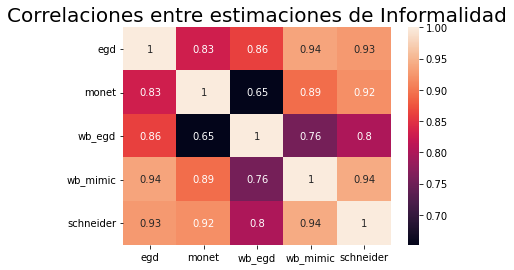

,egd,monet,wb_egd,wb_mimic,schneider
egd,1.000000,0.830862,0.861600,0.936721,0.927676
monet,0.830862,1.000000,0.652008,0.893881,0.919275
wb_egd,0.861600,0.652008,1.000000,0.756255,0.800782
wb_mimic,0.936721,0.893881,0.756255,1.000000,0.941914
schneider,0.927676,0.919275,0.800782,0.941914,1.000000


In [ ]:


ax = sns.heatmap(base_eval[['egd', 'monet', 'wb_egd', 'wb_mimic', 'schneider']].corr(), annot=True)
plt.title('Correlaciones entre estimaciones de Informalidad', fontsize = 20)
plt.show()

base_eval[['egd', 'monet', 'wb_egd', 'wb_mimic', 'schneider']].corr(method='pearson')


In [ ]:
from scipy.stats.stats import pearsonr

#			wb_mimic	schneider
print('EGD')
print(pearsonr(base_eval['egd'], base_eval['monet']))
print(pearsonr(base_eval.query('2002<=fecha<=2017')['egd'], base_eval.query('2002<=fecha<=2017')['wb_egd']))
print(pearsonr(base_eval.query('2002<=fecha<=2018')['egd'], base_eval.query('2002<=fecha<=2018')['wb_mimic']))
print(pearsonr(base_eval.query('2002<=fecha<=2015')['egd'], base_eval.query('2002<=fecha<=2015')['schneider']))
print('monetario')
print(pearsonr(base_eval.query('2002<=fecha<=2017')['monet'], base_eval.query('2002<=fecha<=2017')['wb_egd']))
print(pearsonr(base_eval.query('2002<=fecha<=2018')['monet'], base_eval.query('2002<=fecha<=2018')['wb_mimic']))
print(pearsonr(base_eval.query('2002<=fecha<=2015')['monet'], base_eval.query('2002<=fecha<=2015')['schneider']))



EGD
(0.830861559783021, 5.721808688893367e-06)
(0.861599543274132, 1.794639615126728e-05)
(0.9367213936754928, 3.118713291956552e-08)
(0.9276758709200897, 1.7656804902602693e-06)
monetario
(0.6520084117812881, 0.006200166444360018)
(0.8938811765521592, 1.3266037014906992e-06)
(0.9192746200508752, 3.351302897987159e-06)


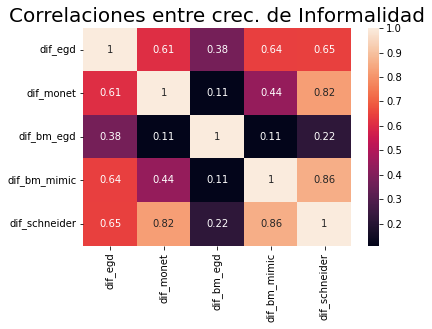

,dif_egd,dif_monet,dif_bm_egd,dif_bm_mimic,dif_schneider
dif_egd,1.000000,0.609641,0.376950,0.642560,0.646855
dif_monet,0.609641,1.000000,0.112602,0.442263,0.824869
dif_bm_egd,0.376950,0.112602,1.000000,0.109793,0.219796
dif_bm_mimic,0.642560,0.442263,0.109793,1.000000,0.858477
dif_schneider,0.646855,0.824869,0.219796,0.858477,1.000000


In [ ]:
ax = sns.heatmap(base_eval[['dif_egd', 'dif_monet', 'dif_bm_egd', 'dif_bm_mimic', 'dif_schneider']].corr(), annot=True)
plt.title('Correlaciones entre crec. de Informalidad', fontsize = 20)
plt.show()

#dif_egd	dif_monet	dif_bm_egd	dif_bm_mimic dif_schneider

base_eval[['dif_egd', 'dif_monet', 'dif_bm_egd', 'dif_bm_mimic', 'dif_schneider']].corr(method='pearson')

In [ ]:


fig = go.Figure()
fig.add_trace(go.Scatter(x=base_eval.query('2002<=fecha<=2018')['fecha'], y= base_eval.query('2002<=fecha<=2019')['informalidad'],
                    
                    mode='lines+markers', 
                    name='EGD',
                     line=dict( width=4))
                     )
fig.add_trace(go.Scatter(x=base_eval.query('2002<=fecha<=2018')['fecha'], y= base_eval.query('2002<=fecha<=2019')['inf_monet'],
                    
                    mode='lines+markers', 
                    name='Monetaria',
                     line=dict( width=4))
                     )
fig.add_trace(go.Scatter(x=base_eval.query('2002<=fecha<=2018')['fecha'], y=base_eval.query('2002<=fecha<=2019')['inform_wb'],
                    mode='lines+markers',
                    name='EGD WB',
                     line=dict( width=1))
              )
fig.add_trace(go.Scatter(x=base_eval.query('2002<=fecha<=2018')['fecha'], y=base_eval.query('2002<=fecha<=2019')['inform_wb_mimic'],
                    mode='lines+markers',
                    name='MIMIC WB',
                     line=dict( width=1)))
fig.add_trace(go.Scatter(x=base_eval.query('2002<=fecha<=2018')['fecha'], y=base_eval.query('2002<=fecha<=2019')['inf_schneider'],
                    mode='lines+markers',
                    name='Schneider 2018',
                     line=dict( width=1))
              )
fig.update_layout(
    title="Estimaciones de Informalidad Honduras 2002-2018",
    xaxis_title="Año",
    yaxis_title="Informalidad (% del PIB)",
    legend_title="Fuente",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=base_eval.query('2005<=fecha<=2021')['fecha'], y= base_eval.query('2005<=fecha<=2021')['informalidad'],
                    text= round(base_eval.query('2005<=fecha<=2021')['informalidad'], 1),
                    textposition='top right',
                    mode='lines+markers+text', 
                    name='EGD',
                     line=dict( width=3))
                     )

fig.add_trace(go.Scatter(x=base_eval.query('2005<=fecha<=2021')['fecha'], y= base_eval.query('2005<=fecha<=2021')['inf_monet'],
                    text= round(base_eval.query('2005<=fecha<=2021')['inf_monet'], 1),
                    textposition='bottom left',
                    mode='lines+markers+text', 
                    name='Monetaria',
                     line=dict( width=3))
                     )

fig.update_layout(
    title="Estimaciones de Informalidad Honduras 2005-2021",
    xaxis_title="Año",
    yaxis_title="% Informalidad",
    legend_title="Métodos",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()


Evaluación de la construción de la variable de stock de capital

In [ ]:
# calculo del stock de capital por el metodo del inventario perpetuo
porc_inv=modelo_EGD['fbc']/modelo_EGD['pib_real']


k_perp=[modelo_EGD['pib_real'][1]*porc_inv.sum()/((modelo_EGD['pib_real'][len(modelo_EGD)]/modelo_EGD['pib_real'][1]-1)+delta)]

for _ in range(len(modelo_EGD)-1):
  k_perp.append(k_perp[-1]*(1-delta)+modelo_EGD['fbc'][_+1])

k_perp


In [ ]:
# Comparacion con datos de stock decapital de FRED (https://fred.stlouisfed.org/series/RKNANPHNA666NRUG : Capital Stock at Constant National Prices for Honduras)

stock_fred=[132854.671875, 135673.859375, 139028.0625, 144821.140625, 149912.46875, 156403.671875, 166065.015625, 176300.59375, 178928.328125, 181840, 187016.578125, 192612.125, 197736.46875, 202852.359375, 209769.6875, 215174.984375, 222287.140625, 230230.5625, 236834.1875, 236834.1875, 0]

modelo_EGD['stock_fred']=stock_fred

modelo_EGD['dif_stock_fred']=100*modelo_EGD['stock_fred']/modelo_EGD['stock_fred'].shift()-100
modelo_EGD['dif_stock_k']=100*modelo_EGD['stock_k']/modelo_EGD['stock_k'].shift()-100

print(modelo_EGD[modelo_EGD['fecha']<=2020][['stock_k', 'stock_fred']].corr(method='pearson'))

print(modelo_EGD[modelo_EGD['fecha']<=2020][['dif_stock_k', 'dif_stock_fred']].corr(method='pearson'))

fig = go.Figure()
fig.add_trace(go.Scatter(x=modelo_EGD[modelo_EGD['fecha']<=2020]['fecha'], y= modelo_EGD[modelo_EGD['fecha']<=2020]['dif_stock_k'],
                    mode='lines+markers',
                    name='dif stock_k'))
fig.add_trace(go.Scatter(x=modelo_EGD[modelo_EGD['fecha']<=2020]['fecha'], y=modelo_EGD[modelo_EGD['fecha']<=2020]['dif_stock_fred'],
                    mode='lines+markers',
                    name='dif stock_fred'))


fig.update_layout(
    title="Relación entre Crecimiento % del Stock de Capital SAR-FRED",
    xaxis_title="Año",
    yaxis_title="%",
    legend_title="Fuente",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()






In [ ]:
fig = px.imshow(round(base_eval[['informalidad', 'inform_wb', 'inform_wb_mimic', 'inf_schneider']].corr(), 2), 
                 labels=dict(x="Correlaciones entre estimaciones de Informalidad de distintas fuentes"),
                x=['SAR', 'WB', 'WB MIMIC', 'Schneider'],
                y=['SAR', 'WB', 'WB MIMIC', 'Schneider'],
                text_auto=True)
fig.update_xaxes(side="top")

fig.show()

base_eval[['informalidad', 'inform_wb', 'inform_wb_mimic', 'inf_schneider']].corr(method='pearson')

,informalidad,inform_wb,inform_wb_mimic,inf_schneider
informalidad,1.000000,0.921951,0.907552,0.922916
inform_wb,0.921951,1.000000,0.756255,0.800782
inform_wb_mimic,0.907552,0.756255,1.000000,0.941914
inf_schneider,0.922916,0.800782,0.941914,1.000000


In [ ]:
fig = px.imshow(round(base_eval[['dif_infor', 'dif_inf_BM', 'dif_inf_BM_MIMIC', 'dif_inf_schneider']].corr(), 2), 
                 labels=dict(x="Correlaciones entre crecimientos de Informalidad de distintas fuentes"),
                x=['SAR', 'WB', 'WB MIMIC', 'Schneider'],
                y=['SAR', 'WB', 'WB MIMIC', 'Schneider'],
                text_auto=True)
fig.update_xaxes(side="top")

fig.show()

base_eval[['dif_infor', 'dif_inf_BM', 'dif_inf_BM_MIMIC', 'dif_inf_schneider']].corr(method='pearson')

,dif_infor,dif_inf_BM,dif_inf_BM_MIMIC,dif_inf_schneider
dif_infor,1.000000,0.008937,0.531483,0.638919
dif_inf_BM,0.008937,1.000000,0.109793,0.219796
dif_inf_BM_MIMIC,0.531483,0.109793,1.000000,0.858477
dif_inf_schneider,0.638919,0.219796,0.858477,1.000000
